In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [3]:
# Test dropout_layer
X = torch.arange(16, dtype=torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0)) # No dropout
print('dropout_p = 0.5:', dropout_layer(X, 0.5)) # Dropout half of the elements
print('dropout_p = 1:', dropout_layer(X, 1)) # Dropout all of the elements

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  4.,  0.,  0.,  0., 12., 14.],
        [16.,  0.,  0., 22., 24.,  0.,  0.,  0.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


# Define the model

In [5]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

# Training

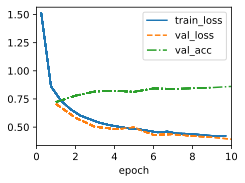

In [8]:
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
           'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLP(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [10]:
def show_wrongpreds(data):
    X, y = next(iter(data.val_dataloader()))
    preds = model(X).argmax(1)
    preds[:10], y[:10]
    accuracy = (preds == y).float().mean()
    print(f'accuracy: {accuracy:.2f}')
    wrong = preds.type(y.dtype) != y
    X, y, preds = X[wrong], y[wrong], preds[wrong]
    labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
    data.visualize([X, y], labels=labels)

accuracy: 0.87


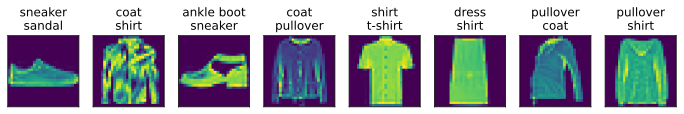

In [11]:
show_wrongpreds(data)

# Concise implementation

In [12]:
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
                 dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
            nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

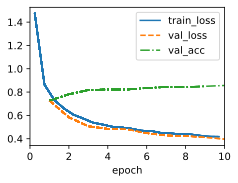

In [13]:
model = DropoutMLP(**hparams)
trainer.fit(model, data)